In [1]:
from utils import set_pyplot_params
set_pyplot_params()

Nel capitolo precedente abbiamo calcolato la distribuzione delle somme.
In questo capitolo, calcoleremo distribuzioni di minimi e massimi e useremo questo per risolvere sia il problema in avanti che il problema inverso.

Ora guarderemo le distribuzioni che sono composte da altre distribuzioni, questo si rivelerà utile per fare delle previsioni.
Ma prima partiamo da un potente strumento per lavorare con le distribuzioni, la funzione di distribuzione cumulativa.

## Funzione di distribuzione cumulativa
Dunque abbiamo usato la funzione di probabilità che rappresenta le distribuzioni. Un uso alternativo è la **funzione di distribuzione cumulativa** o CDF. 

Come esempio la useremo questo per calcolare la distribuzione a posteriori per il problema dell'Euro che abbiamo già visto in passato.

Qui la distribuzione a priori con cui siamo partiti.

In [2]:
import numpy as np
from distribution import Pmf

hypos = np.linspace(0, 1, 101)
pmf = Pmf(1, hypos)
data = 140, 250

E qui la funzione di aggiornamento.

In [3]:
from scipy.stats import binom

def update_binomial(pmf, data):
    """Update pmf using the binomial distribution."""
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [4]:
update_binomial(pmf, data)

La funzione CDF è la somma cumulativa del PMF, dunque possiamo calcolare la probabilità in questo modo:

In [5]:
cumulative = pmf.cumsum()

Ed ecco come appare assieme al PMF.

In [6]:
from utils import decorate

def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

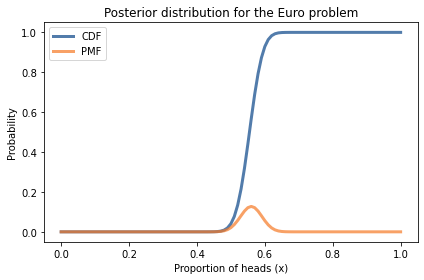

In [7]:
cumulative.plot(label='CDF')
pmf.plot(label='PMF')
decorate_euro(title='Posterior distribution for the Euro problem')

Il range della funzione cumulativa è sempre tra 0 e 1, in contrasto con la funzione PMF dove il massimo può essere una probabilità. Il risultato di `cumsum` è una `Series` Pandas, possiamo usare l'operatore parentesi quadra per selezionare un elemento:

In [8]:
cumulative[0.61]

0.9638303193984252

Il risultato è circa 0.96, che significa che la probabilità totale di tutte le quantità minori o uguali a 0.61 rappresenta il 96%

Per vederla in un altro modo per cercare la probabilità e ottenere il corrispondente quantile possiamo usare l'interpolazione:

In [9]:
from scipy.interpolate import interp1d

ps = cumulative.values
qs = cumulative.index

interp = interp1d(ps, qs)
interp(0.96)

array(0.60890171)

Il risultato è circa il 0.61, questo conferma che il 96° percentile della distribuzione è 0.61.
L'oggetto `Pmf` ci permette di usare la classe `Cdf` che ci da accesso alla funzione di distribuzione cumulativa.

In [10]:
cdf = pmf.make_cdf()

`make_cdf` usa `np.cumsum` per calcolare la somma cumulativa delle probabilità.

In [11]:
cdf[0.61]

0.9638303193984252

Ma se volessimo ottenere una quantità che non è nella distribuzione otteniamo un `KeyError`.

In [12]:
try:
    cdf[0.615]
except KeyError as e:
    print(repr(e))

KeyError(0.615)


Per ovviare a questo problema possiamo usare `Cdf` come una funzione usando le parentesi.
Se questo argomento non appare in `Cdf`, il valore viene interpolato tra le quantità.

In [13]:
cdf(0.615)

array(0.96383032)

Possiamo usare la funzione `quantile` per ottenere dalla probabilità cumulativa la corrispondente quantità:

In [14]:
cdf.quantile(0.9638303)

array(0.61)

`Cdf` ci da la possibilità di usare `credible_interval`,  per calcolare l'intervallo di credibilità:

In [15]:
cdf.credible_interval(0.9)

array([0.51, 0.61])

Gli oggetti CDF e PMF sono equivalenti nel senso che contengono le stesse informazioni sulla distribuzione e possiamo sempre convertire una nell'altra. 

Dato un oggetto `Cdf` possiamo ottenere l'equivalente  `Pmf` così:

In [16]:
pmf = cdf.make_pmf()

`make_pmf` usa `np.diff` per calcolare le differenze tra probabilità cumulative consecutive.
Una ragione per usare l'oggetto `Cdf` è che viene facile calcolare i quantili in modo efficiente.
Un'altra è che viene facile calcolare la distribuzione del massimo o minimo come vedremo nell prossima sezione.

## Il meglio dei tre di quattro

Nel gioco *dangeons and dragons* ogni personaggio ha 6 attributi: forza, intelligenza, saggezza, destrezza, costituzione e carisma.

Per generare il personaggio, i giocatori lanciano quattro dadi da sei facce per ogni attributo e sommano i migliori dei tre.
Per esempio, se lancio i dadi per la forza e ottengo 1,2,3,4 sui dadi il mio personaggio avrà una forza pari a 9.

Come esercizio, immaginiamo la distribuzione di questi attributi.
Poi per ogni carattere, immaginiamo la distribuzione dei loro attributi migliori.

Usiamo due funzioni del capitolo precedente `make_die`, che crea un oggetto `Pmf` che rappresenta i risultati del lancio dei dadi e `add_dist_seq`, che prende una sequenza di oggetti `Pmf` e calcola la distribuzione della loro somma.

Qui un oggetto `Pmf` che rappresenta un dado a 6 facce e una sequenza di tre lanci:

In [17]:
from utils import make_die

die = make_die(6)
dice = [die] * 3

In [18]:
from utils import add_dist_seq

pmf_3d6 = add_dist_seq(dice)

Qui la distribuzione visuale:

In [19]:
def decorate_dice(title=''):
    decorate(xlabel='Outcome',
             ylabel='PMF',
             title=title)

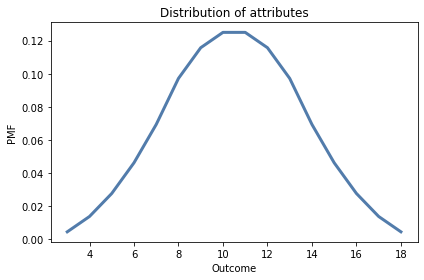

In [20]:
pmf_3d6.plot()
decorate_dice('Distribution of attributes')

Se lanciamo quattro dadi e sommiamo i tre migliori risultati, calcolare la distribuzione della somma è più complicato.
Stimeremo la distribuzione simulando 10'000 lanci.

Prima creiamo un array con dei valori casuali tra 1 e 6 con 10'000 righe e 4 colonne:

In [21]:
n = 10000
a = np.random.randint(1, 7, size=(n, 4))

Per trovare i tre migliori risultati di ogni riga ordiniamo usando la funzione `sort` con il parametro `axis=1`, che ordina le righe in ordine ascendente.

In [22]:
a.sort(axis=1)

Finalmente, sceglieremo i tre migliori risultati e li sommiamo.

In [23]:
t = a[:, 1:].sum(axis=1)

Ora `t` è un array con una singola colonna e 10'000 righe.
Possiamo calcolare il PMF dei valori di `t` in questo modo:

In [24]:
pmf_best3 = Pmf.from_seq(t)

Il seguente grafico mostra la distribuzione delle somme dei tre dadi.

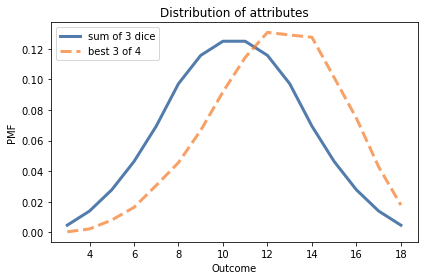

In [25]:
pmf_3d6.plot(label='sum of 3 dice')
pmf_best3.plot(label='best 3 of 4', style='--')

decorate_dice('Distribution of attributes')

Come ci si aspetta, scegliere il migliore dei tre valori su 4 tende a dare valori più alti.
Ora troviamo la distribuzione del massimo dei 6 attriburi, ogni uno è la somma dei tre risultati migliori.

## Massimo

Per calcolare il massimo o il minimo della distribuzione, possiamo far buon uso della distribuzione cumulativa.
Per prima cosa calcoliamo il `Cdf` delle tre migliori delle 4 distribuzioni:

In [26]:
cdf_best3 = pmf_best3.make_cdf()

Ricorda che `Cdf(x)` è la somma delle probabilità per i quantili minori o uguali di `x`.
Si può dire anche che è la probabilità che un valore a caso scelto dalla distribuzione sia minore o uguale a `x`.

Ora supponiamo si avere i 6 valori della distribuzione. La probabilità che tutti e 6 i valori siano minori o uguali a `x` è `Cdf(x)` elevato alla sesta, che possiamo calcolare facilmente in questo modo:

In [27]:
cdf_best3**6

3     7.290000e-22
4     2.441406e-16
5     1.340096e-12
6     3.705175e-10
7     3.614157e-08
8     1.201025e-06
9     2.396769e-05
10    3.212346e-04
11    2.830219e-03
12    1.696421e-02
13    6.618243e-02
14    1.982419e-01
15    4.183060e-01
16    6.872319e-01
17    8.978413e-01
18    1.000000e+00
Name: , dtype: float64

Se tutti e 6 i valori sono minori o uguali di `x`, questo signfica che il loro massimo è minoro o uguare a `x`.
Quindi il risultato è il CDF del loro massimo.

Possiamo convertirlo in un oggetto `Cdf` in questo modo:

In [28]:
from distribution import Cdf

cdf_max6 = Cdf(cdf_best3**6)

Calcoliamo l'equivalente Pmf in questo modo:

In [29]:
pmf_max6 = cdf_max6.make_pmf()

Il seguente grafico mostra i risultati.

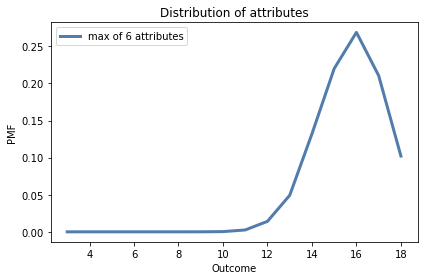

In [30]:
pmf_max6.plot(label='max of 6 attributes')

decorate_dice('Distribution of attributes')

Molte delle caratteristiche hanno almeno un attributo maggiore di 12 e almeno il 10% hanno un valore 18.
Il seguente grafico mostra i CDF delle tre distribuzioni che abbiamo calcolato.

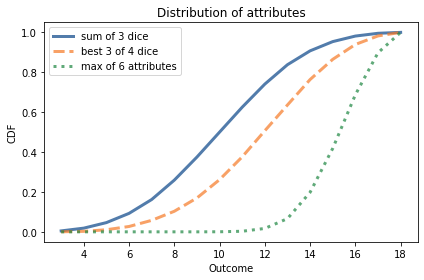

In [31]:
import matplotlib.pyplot as plt

cdf_3d6 = pmf_3d6.make_cdf()
cdf_3d6.plot(label='sum of 3 dice')

cdf_best3 = pmf_best3.make_cdf()
cdf_best3.plot(label='best 3 of 4 dice', style='--')

cdf_max6.plot(label='max of 6 attributes', style=':')

decorate_dice('Distribution of attributes')
plt.ylabel('CDF');

L'oggetto `Cdf` fornisce un oggetto `max_dist` che esegue gli stessi calcoli, dunque possiamo calcolare il massimo del `Cdf` come il massimo in questo modo:

In [32]:
cdf_max_dist6 = cdf_best3.max_dist(6)

E qui confermiamo che le differenze sono piccole.

In [33]:
np.allclose(cdf_max_dist6, cdf_max6)

True

Nella prossima sezione troveremo la distribuzione del minimo.
Questo processo è simile, ma leggermente più complicato.

## Minimo

Nella sezione precedente abbiamo calcolato la distribuzione dei migliori attributi per il personaggio.
Calcoliamo ora la distribuzione del peggiore.
Per calcolare la distribuzione del minimo useremo il **CDF complementare**, che viene calcolato nel seguente modo:


In [34]:
prob_gt = 1 - cdf_best3

Come suggerito dalla variabile, il CDF complementare rappresenta la probabilità che un valore della distribuzione sia maggiore di `x`.

Se otteniamo 6 valori dalla distribuzione, la probabilità che tutti e 6 superino `x` è:

In [35]:
prob_gt6 = prob_gt**6

Se tutte e 6 eccedono `x`, questo significa che il loro minimo supera `x`, dunque `prob_gt6` è complementare al CDF del minimo.
E questa significa che possiamo calcolare il CDF del minimo in questo modo:

In [36]:
prob_le6 = 1 - prob_gt6

Il risultato è un oggetto `Series` di Pandas che rappresenta il CDF del minimo dei sei attributi. Possiamo mettere i valori in un oggetto `Cdf` in questo modo:

In [37]:
cdf_min6 = Cdf(prob_le6)

Ecco come appare assieme alla distribuzione assieme alla distribuzione del massimo:

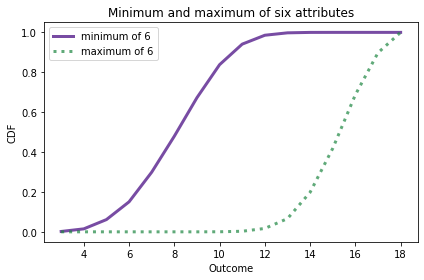

In [38]:
cdf_min6.plot(color='C4', label='minimum of 6')
cdf_max6.plot(color='C2', label='maximum of 6', style=':')
decorate_dice('Minimum and maximum of six attributes')
plt.ylabel('CDF');

L'oggetto `Cdf` fornisce il metodo `min_dist`,che esegue gli stessi calcoli:

In [39]:
cdf_min_dist6 = cdf_best3.min_dist(6)

E confermiamo che le differenze sono minuscole.

In [40]:
np.allclose(cdf_min_dist6, cdf_min6)

True

Negli esercizi alla fine del capitolo, useremo le distribuzioni del minimo e del massimo per fare delle inferenze Bayesiane.
Ma prima vediamo cosa succede se mescoliamo le distribuzioni.

## Miscela

In questa sezione, mostreremo come calcolare la distribuzione che rappresenta una miscela di altre distribuzioni.
Spiegheremo cosa significa con alcuni semplici esempi; vedremo poi come queste miscele possano essere utilizzate per fare delle previsioni.

Qui un altro esempio insipirato da *Dungeons & Dragons*:

* Supponiamo che il personaggio sia armato con un pungale in una mano e una spada corta nell'altra.
* Durante ogni round, attacchiamo  il mostro con una delle due armi scelta a caso.
* Il pugnale causa un danno scelto da un dado a 4 facce, la spada corta causa un danno un danno scelto da un danno da 6 facce.

Quale è la distribuzione del danno inflitto a ogni round?

Per rispondere alla domanda, Creiamo due oggetti `Pmf` per rappresentare un dado a 4 e 6 facce:

In [41]:
d4 = make_die(4)
d6 = make_die(6)

Ora, calcoliamo la probabilità di infliggere un punto di danno.

* Se attacchiamo con il pugnale è 1/4
* Se attacchiamo con la spada è 1/6.

In quanto la probabilità di scegliere una arma è 1/2 la probabilità totale è la media:

In [42]:
prob_1 = (d4(1) + d6(1)) / 2
prob_1

0.20833333333333331

Per i risultati 2, 3 e 4 la probabilità è la stessa ma per 5 e 6, perchè i risultati sono impossibili per un dado a 4 facce.

In [43]:
prob_6 = (d4(6) + d6(6)) / 2
prob_6

0.08333333333333333

Per calcolare la distribuzione della miscela, possiamo iterare su tutti i possibili risultati e calcolare le loro probabilità.
Ma possiamo fare gli stessi calcoli usando l'operatore  `+`:

In [44]:
mix1 = (d4 + d6) / 2

Qui la miscela delle distribuzioni.

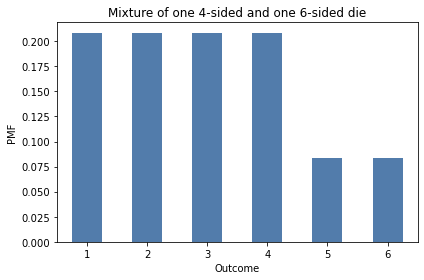

In [45]:
mix1.bar(alpha=0.7)
decorate_dice('Mixture of one 4-sided and one 6-sided die')

Ora supponiamo che stiamo combattendo tre mostri:

* uno ha una clava, che causa un danno scelto da un dado a 4 facce.

* uno ha una mazza che causa un danno scelto da un dado a 6 facce.

* e un altro ha una mazza ferrata, che causa anche lui un danno scelto da un dado a 6 facce. 

Visto che la mischia è disorganizzata, attacchiamo uno di questi mostri alla volta scelto a caso.
Per trovare la distribuzione del danno che infliggono, possiamo calcolare la media pesata delle distribuzioni in questo modo:

In [46]:
mix2 = (d4 + 2*d6) / 3

La distribuzione è una miscela di uno dei dadi a 4 facce e due dadi a 6 facce.
Qui come si visualizza la distribuzione.

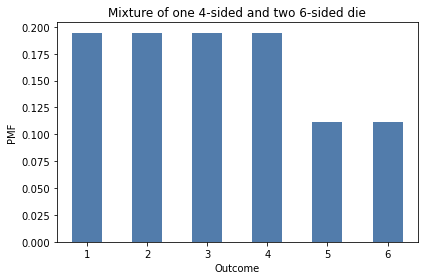

In [47]:
mix2.bar(alpha=0.7)
decorate_dice('Mixture of one 4-sided and two 6-sided die')

In questa sezione abbiamo usato l'operatore `+` che aggiunge le probabilità nelle distribuzioni, non deve essere confuso con `Pmf.add_dist`che calcola la distribuzione come la somma delle distribuzioni:

In [48]:
total_damage = Pmf.add_dist(mix1, mix2)

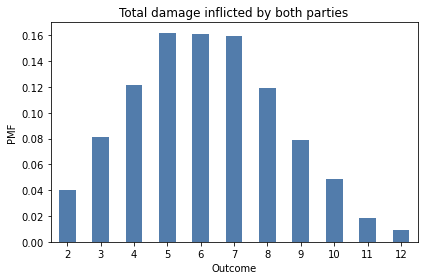

In [49]:
total_damage.bar(alpha=0.7)
decorate_dice('Total damage inflicted by both parties')

## Miscele Generalizzate

Nella sezione precedente abbiamo calcolato le miscele in modo *ad hoc*.
Ora vedremo come vedere una soluzione generalizzata.
Nei capitoli futuri, vedremo questa soluzione per generalizzare le previsioni nei problemi reali, non solo per i giochi di ruolo.
Ma con un pochino di pazienza, continueremo gli esempi precedenti per una ulteriore sezione.

Supponiamo che i tre mostri si uniscano nel combattimento, ognuno di essi con una ascia di battaglia con un dado a 8 facce per i danni.

Ancora, solo un mostro attacca per turno, scelto a caso, il danno che infliggono è una miscela di:

* Un dado a 4 facce,
* Due dadi a 6 facce,
* Tre dadi a 8 facce.

Useremo l'oggetto `Pmf` per rappresentare un mostro scelto a caso:

In [50]:
hypos = [4,6,8]
counts = [1,2,3]
pmf_dice = Pmf(counts, hypos)
pmf_dice.normalize()
pmf_dice

,probs
4,0.166667
6,0.333333
8,0.500000


Questa distribuzione rappresenta il numero dei lati di ciascun dado e la probabilità di ciascun lato.
Per esempio, uno dei sei mostri ha un pugnale, dunque abbiamo che la probabilità di lanciare un dado a 4 facce è un $1/6$.

Poi creereno una sequenza di oggetti `Pmf` per rappresentare il dado:

In [51]:
dice = [make_die(sides) for sides in hypos]

Per calcolare la distribizione della miscela, calcoleremo la media pesata del dado usando le probabilità di `pmf_dice` come pesi.

Per esprimere questo calcolo è conveniente mettere le distribuzioni Pandas `DataFrame`:

In [52]:
import pandas as pd

pd.DataFrame(dice)

,1,2,3,4,5,6,7,8
,0.250000,0.250000,0.250000,0.250000,NaN,NaN,NaN,NaN
,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,NaN,NaN
,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125,0.125


Il risultato è un `DataFrame`con una riga per ogni distribuzione e una colonna per ogni risultato.
non tutte le righe sono di egual lunghezza, dunque pandas riempie gli spazi con dei caratteri speciali `NaN`, che sta per "not a number".

Possiamo usare `fillna` per rimpiazzare e valori `NaN` con 0.

Il prossimo passo è quello di moltiplicare le righe con le probabilità `pmf_dice`, che risulta essere più facile da lavorare se trasponiamo la matrice delle distribuzioni che trasforma le righe in colonne:

In [53]:
df = pd.DataFrame(dice).fillna(0).transpose()
df

,,,
1,0.25,0.166667,0.125
2,0.25,0.166667,0.125
3,0.25,0.166667,0.125
4,0.25,0.166667,0.125
5,0.00,0.166667,0.125
6,0.00,0.166667,0.125
7,0.00,0.000000,0.125
8,0.00,0.000000,0.125


Ora possiamo moltiplicare le probabilità in `pmf_dice`:

In [54]:
df *= pmf_dice.ps

In [55]:
df

,,,
1,0.041667,0.055556,0.0625
2,0.041667,0.055556,0.0625
3,0.041667,0.055556,0.0625
4,0.041667,0.055556,0.0625
5,0.000000,0.055556,0.0625
6,0.000000,0.055556,0.0625
7,0.000000,0.000000,0.0625
8,0.000000,0.000000,0.0625


E sommiamo le distribuzioni pesate:

In [56]:
df.sum(axis=1)

1    0.159722
2    0.159722
3    0.159722
4    0.159722
5    0.118056
6    0.118056
7    0.062500
8    0.062500
dtype: float64

L'argomento `axis=1` significa che vogliamo sommare i valori sulle righe. Il risultato è una serie Pandas.
Mettere tutto essieme creiamo una funzione che crea una miscela delle distribuzioni.

In [57]:
def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions."""
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)

Il primo parametro è un oggetto `Pmf` che mappa ogni ipotesi in probabilità.
Il secondo parametro è una sequenza di oggetti `Pmf` uno per ogni ipotesi.

Possiamo usarlo così:

In [58]:
mix = make_mixture(pmf_dice, dice)

e qui il risultato

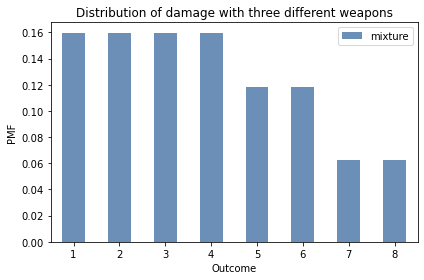

In [59]:
mix.bar(label='mixture', alpha=0.6)
decorate_dice('Distribution of damage with three different weapons')

In questa sezionne abbiamo usato Pandas per creare `make_mixture` una funzione efficiente e molto utile.
Useremo la funzione `make_mixture` nel prossimo capitolo.

## Sommario

Questo capitolo introduce l'oggetto `Cdf`, che rappresenta la funzione di distribuzione cumulativa.

Un `Pmf` e il corrispondente `Cdf` sono equivalente nel senso che contengno le stesse informazioni, duqnue possiamo convertire una forma in un'altra.

La differenza primaria tra loro è le performace: alcune operazioni sono veloci e semplici con il `Pmf`; altre sono veloci con l'oggetto `Cdf`.

In questo capitolo abbiamo usato gli oggetti `Cdf` per calcolare le distribuzioni del massimo e del minimo; queste distribuzioni sono utili per l'inferenza se ci viene fornito un massimo un minimo come dato.

Vedremo alcuni esempi negli esercizi e nei capitoli futuri.
Abbiamo anche calcolare le miscele di distribuzioni, che potremo usare nel prossimo capitolo per fare previsioni.

## Esercizi

**Esercizio:** Quando generiamo un personaggio di D&D, invece di lanciare i dadi, possiamo usare lo "standard array" degli attributi che ha valore 15, 14, 13, 12, 10 e 8.

Pensi che sia meglio usare lo standard arrao o lanciare i dadi?
Compara i valori delle distribuzioni nello standard array rispetto ai valori che abbiamo calcolato per il migliori tre dei quattro:

* Quale distribuzione ha la media più alta? Usare il metodo `mean`.
* Quale distribuzione ha la deviasione standard più alta? Usare il metodo `std`.
* Il valore minimo nello standard array è 8. Per ogni attributo quale è la probabilità di ottenere un valore minore di 8? Se lanciamo il dado sei volte, quale è la probabilità che almeno un attributo sia meno di 8?
* Il valore più alto dello standard array è 15.Per ogni attributo quale è la probabilità di ottenere un valore più grande di 15? Se lancio il dado 6 volte quale è la probabilità che almeno un attributo sia maggiore di 15?

Per partire, qui la rappresentazione `Cdf` che rappresenta la distribuzione degli attributi nello standard array:

In [60]:
standard = [15,14,13,12,10,8]
cdf_standard = Cdf.from_seq(standard)

Possiamo comparali con la distribuzione degli attributi che ottieni sommando i migliori tre risultati di quattro.

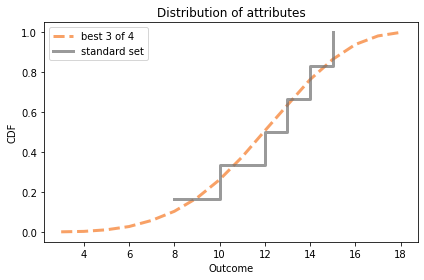

In [61]:
cdf_best3.plot(label='best 3 of 4', color='C1', style='--')
cdf_standard.step(label='standard set', color='C7')

decorate_dice('Distribution of attributes')
plt.ylabel('CDF');

Ho visualizzato il dato `cdf_standard` come una funzione gradino per mostrare chiaramente che contiene solo poche quantità.

In [62]:
cdf_best3.mean(),cdf_best3.mean()

(12.2988, 12.2988)

In [63]:
cdf_best3.std(), cdf_standard.std()

(2.8440672565887044, 2.3804761428476167)

In [64]:
cdf_best3.lt_dist(8)

0.057499999999999996

In [65]:
cdf_best3.gt_dist(15)

0.1352

In [66]:
#calcolo la probabilità che lanciando il dado 6 volte almeno un attributo sia minore di 8

cdf_min6.lt_dist(8), 1 - (1-cdf_best3.lt_dist(8))**6

(0.2990482033172146, 0.2990482033172146)

In [67]:
#calcolo la probabilità che lanciando il dado 6 volte almeno un attributo sia maggiore di 15

cdf_max6.gt_dist(15), 1 - (1-cdf_best3.gt_dist(15))**6

(0.5816940079806041, 0.5816940079806041)

**Esercizio** Supponiamo che stiamo combattendo tre mostri:
* Uno è armato con una spada corta che causa un danno derivato da un dado a 6 facce, 
* Uno è armato con una ascia da battaglia che causa un danno derivato da un dado a 8 facce, 
* Uno è armato con una spada bastarda che causa un danno derivato da un dado a 10 facce.


Il mostro viene scelto in modo casuale, ti attacca e fa un punto di danno.
Quale mostro piensi sia stato? Calcola la probabilità a posteriori per ciascun attacante.
Se lo stesso mostro ti attacca nuovamente, quale è la probabilità che tu abbia 6 punti di danno?

Suggerimento: Calcola a posteriori la distribuzione che abbiamo fatto prima e passa come un argomento alla funzione `make_mixture`.

In [68]:
hypos = [6, 8, 10]
prior = Pmf(1, hypos)
likelihood = 1/prior.qs
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
6,0.425532
8,0.319149
10,0.255319


In [69]:
d6 = make_die(6)
d8 = make_die(8)
d10 = make_die(10)

dice = d6, d8, d10

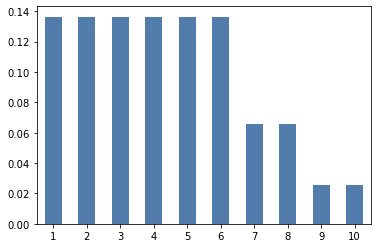

In [70]:
mix3 = make_mixture(posterior, dice)
mix3.bar()

In [71]:
mix3[6]

0.13634751773049647

**Esercizio:** Henri Poincaré è stato un matematico Francese che insegnò alla Sorbona attorno al 1900. Il seguente aneddoto su di lui è probabilmente una finzione ma ci da uno spunto su un interessante problema.

Poincaré sospettava che il suo panettiere gli stesse vendendo delle pagnotte più leggere del peso concordato di 1 k, dunque per un anno comprò e pesò le stesse. Alla fine dell'anno stampò e visualizzò le misure mostrando che questa era conforme ad una distribuzione normale con media di 950g e una deviazione standard di 50g.

Portò questa evidenza alla polizia del pane che ha avvertito il fornaio.
Nell'anno successivo, Poincarè continuò a pesare il suo pane ogni giorno. Alla fine dell'anno trovò che la media del pane era di 1000g, come avrebbe dovuto essere, ma ancora si lamentò com la polizia del pane che questa voltà multò il panettiere.

Questo perchè la forma della nuova distribuzione era asimmetrica. Invece della distribuzione normale, questa era pendente verso destra, il che è coerente con l'ipotesi che il fornaio stesse facendo ancora pagnotte da 950g ma che stesse dando le più pesanto a Poincaré.

Per capire se questo aneddoto è plausibile, supponiamo che quando il panettiere vede Poincaré arrivare, prende  `n` pagnotte di pane e da a Poincaré quella più pesante. Quante pagnotte dovrebbe pesare il fornaio per creare la media del massimo di 1000g?

In [72]:
mean = 950
std = 50

np.random.seed(17)
sample = np.random.normal(mean, std, size=365)

In [73]:
cdf = Cdf.from_seq(sample)

for n in range(2, 6):
    cdf_max = cdf.max_dist(n)
    print(n, cdf_max.mean())

2 978.4666876067706
3 992.7589004318227
4 1002.0372868686195
5 1008.8226939493089


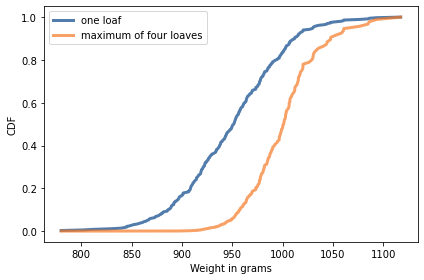

In [74]:
cdf.plot(label='one loaf')
cdf.max_dist(4).plot(label='maximum of four loaves')

decorate(xlabel='Weight in grams',
         ylabel='CDF')